# Topic Modelling

_UNDER CONSTRUCTION_

- Topic Models: FOMC meeting minutes text
- Matrix Decomposition: NMF, LSA, LDA, PLSI



In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
import sklearn.feature_extraction, sklearn.decomposition
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from scipy.special import softmax
from wordcloud import WordCloud
import wordcloud
import matplotlib.pyplot as plt
from finds.database.mongodb import MongoDB
from finds.unstructured import Unstructured
from finds.unstructured.store import Store
from finds.readers.fomcreader import FOMCReader
from finds.readers.alfred import Alfred
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 1      # 0
SHOW = dict(ndigits=4, latex=True)  # None

In [2]:
mongodb = MongoDB(**credentials['mongodb'])
fomc = Unstructured(mongodb, 'FOMC')
imgdir = paths['images'] / 'fomc'

{'host': 'omen3080', 'version': '5.0.20', 'process': 'mongod', 'pid': 4153196, 'uptime': 931.0, 'uptimeMillis': 931239, 'uptimeEstimate': 931, 'localTime': datetime.datetime(2023, 8, 31, 18, 13, 46, 746000), 'asserts': {'regular': 0, 'warning': 0, 'msg': 0, 'user': 19, 'tripwire': 0, 'rollovers': 0}, 'catalogStats': {'collections': 7, 'capped': 0, 'timeseries': 0, 'views': 0, 'internalCollections': 3, 'internalViews': 0}, 'connections': {'current': 6, 'available': 51194, 'totalCreated': 8, 'active': 3, 'threaded': 6, 'exhaustIsMaster': 0, 'exhaustHello': 1, 'awaitingTopologyChanges': 2}, 'electionMetrics': {'stepUpCmd': {'called': 0, 'successful': 0}, 'priorityTakeover': {'called': 0, 'successful': 0}, 'catchUpTakeover': {'called': 0, 'successful': 0}, 'electionTimeout': {'called': 0, 'successful': 0}, 'freezeTimeout': {'called': 0, 'successful': 0}, 'numStepDownsCausedByHigherTerm': 0, 'numCatchUps': 0, 'numCatchUpsSucceeded': 0, 'numCatchUpsAlreadyCaughtUp': 0, 'numCatchUpsSkipped': 

In [3]:
## retrieve recessions dates for plotting
alf = Alfred(api_key=credentials['fred']['api_key'])
vspans = alf.date_spans()

## Scrape FOMC Minutes text


In [4]:
dates = fomc['minutes'].distinct('date')       # check dates stored in MongoDB

In [5]:
## retrieve from FOMC website
catalog = FOMCReader.fetch()    # check for new dates in FOMC site, and retrieve
print(f"FOMC: {len(catalog)} dates {min(catalog.keys())}-{max(catalog.keys())}")
docs = {d: FOMCReader.fetch(url) for d, url in catalog.items() if d not in dates}
print('NEW:', ", ".join([f"{k}: {len(v)} chars" for k,v in docs.items()]))

FOMC: 244 dates 19930203-20230726
NEW: 


__Filter raw text__

- Minutes file usually start with sentences about:

  - developments in domestic financial markets and system open market transactions; or 
  - discusion of economic and financial outlook and implementation of monetary policy; sometimes
  - staff presentations on ad-hoc policy topics
  - discussion ad-hoc issues such as "balance sheet normalization" in recent years

- keep text approximately from (i.e. skip earlier organizational items):

  - "Developments in Financial Markets" or
  - "Discussion of Guideliness for Policy Normalizatio" or
  - "Financial Developments and Open Market Operations" or
  - "discussion of the economic outlook" or
  - "the information reviewed at this meeting" or
  - "the staff presented several briefings"
  
- skip earlier which merely re-affirmation of general policy statement
- delete after adjourn line, i.e. after schedule next meeting,
- ignore notation votes, minutes approvals, signature, and footnotes
- ignore intermeeting conference calls


In [6]:
import subprocess
import tempfile
def edit(text: str) -> str:
    """helper to spawn editor and write/read/write to tempfile"""
    with tempfile.NamedTemporaryFile(suffix=".tmp") as f: # save temp file
        f.write(text.encode("utf-8"))
        f.flush()
        subprocess.call([os.environ.get('EDITOR','emacs'), "-nw", f.name])
        f.seek(0)
        return f.read().decode("utf-8")        # keep edited text

In [7]:
if docs:
    ## loop to edit out head and tail of document
    results = list()   
    for date, initial_message in docs.items():  # manually trim text
        edited_text = edit(initial_message)
        results.append({'date': date, 'text' : edited_text})
        results = sorted(results, key = lambda x: x['date'])   # sort by date

    ## save the new edited docs
    Store(paths['scratch'], ext='gz').dump(results, 'fomc')
    for doc in results: # store docs for new dates
        fomc.insert('minutes', doc, keys=['date'])

In [8]:
# Retrieve and preprocess text
docs = Series({doc['date']: doc['text'] for doc in fomc.select('minutes')},
              name='minutes').sort_index()
DataFrame(docs)

,minutes
19930203,The Manager of the System Open Market Account ...
19930323,The Deputy Manager for Domestic Operations rep...
19930518,The Manager of the System Open Market Account ...
19930707,The Deputy Manager for Domestic Operations rep...
19930817,The Deputy Manager for Domestic Operations rep...
...,...
20230201,Developments in Financial Markets and Open Mar...
20230322,Recent Developments in the Banking Sector \nBe...
20230503,Developments in Financial Markets and Open Mar...
20230614,Developments in Financial Markets and Open Mar...


In [9]:
## set stop words and vectorize inputs
StopWords = [w for w in set(wordcloud.STOPWORDS) if "'" not in w]
StopWords += ['january', 'february', 'march', 'april', 'may', 'june',
              'july', 'august', 'september', 'october', 'november',
              'december', 'first', 'second', 'third', 'fourth', 'twelve',
              'participants', 'members', 'meeting']
ngram_range = (1,1) # (1, 2)
max_df, min_df, max_features = 0.5, 6, 5000 # some reasonable constraints
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,        # (2, 2) for bigrams
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b") #r'\b[^\d\W]+\b'
tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,        # (2, 2) for bigrams
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")

## Topic models

In [10]:
# Define models
n_components = 4
algos = {
    'LSA': (TruncatedSVD(n_components=n_components),
            tfidf_vectorizer),
    'LDA': (LatentDirichletAllocation(n_components=n_components,
                                      learning_method='batch', #'online',
                                      # learning_offset = 50.0,
                                      max_iter = 40,
                                      random_state = 42), tf_vectorizer),
    'PLSI': (NMF(n_components=n_components,
                 beta_loss='kullback-leibler',
                 solver='mu', 
                 alpha_W=0.00005,
                 alpha_H=0.00005,
                 l1_ratio=0.5,
                 max_iter=1000,
                 random_state = 42),
             tfidf_vectorizer),
    'NMF': (NMF(n_components=n_components,
                random_state=42,
                beta_loss='frobenius',
                alpha_W=0.00005,
                alpha_H=0.00005,
                l1_ratio=0.5),
            tfidf_vectorizer)}

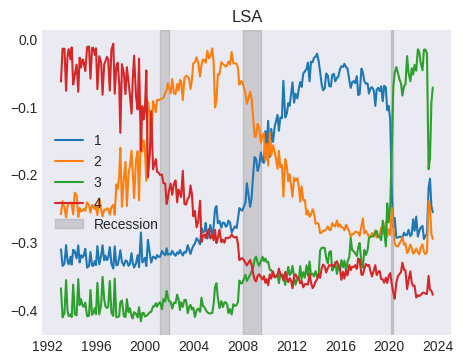

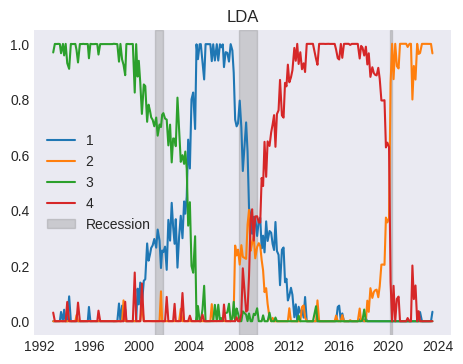

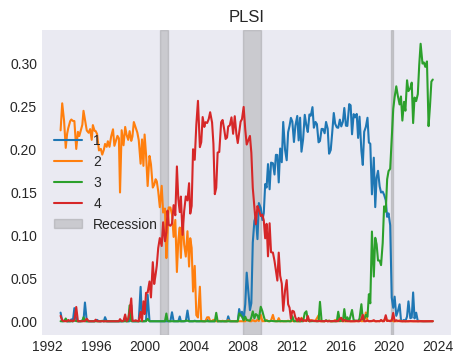

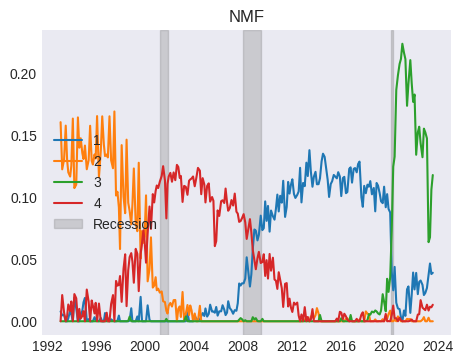

In [11]:
## Fit and plot models
scores = dict()
dates = dict()
for ifig, (name, (base, vectorizer)) in enumerate(algos.items()):
    vectorized = vectorizer.fit_transform(docs.to_list())
    feature_names = vectorizer.get_feature_names_out()
    model = base.fit(vectorized)
    topics = model.transform(vectorized)
    if name == 'LSA':  # Additional step for LSA
        kmeans = KMeans(n_clusters=n_components,
                        n_init=5,
                        random_state=37)\
                        .fit(topics)   # find centroids of the latent factors
        topics = kmeans.transform(topics)  # distance of document to centroid
        topics = -(topics / topics.sum(axis=1, keepdims=True)) # as similarity
        scores[name] = softmax(model.components_, axis=1)  # scale word scores
    else:
        scores[name] = model.components_
    fig, ax = plt.subplots(num=1 + ifig, clear=True, figsize=(5, 4))
    date = pd.DatetimeIndex(docs.index.astype(str))        
    ax.plot(date, topics)
    for a,b in vspans:
        if b >= min(date):
            ax.axvspan(a, min(b, max(date)), alpha=0.3, color='grey')
    ax.set_title(name)
    ax.legend([f"{i+1}" for i in range(n_components)] + ['Recession'],
              loc='center left')
    plt.tight_layout(pad=2)
    for topic in range(topics.shape[1]):
        arg = DataFrame({'t': np.argmax(topics, axis=1),
                         'dt': docs.index})
        g = (arg!=arg.shift()).cumsum().groupby('t').agg(['first', 'last']) - 1
        g['topic'] = arg.loc[g.iloc[:,1], 't'].values
    dates[name] = {topic: [(arg['dt'].iloc[row[0]],
                            arg['dt'].iloc[row[1]])
                           for row in g.itertuples(index=False, name=None)
                           if row[2] == topic]
                   for topic in range(topics.shape[1])}
    plt.savefig(imgdir / (name + '_topics.jpg'))

Topic 1 {0: [(20091104, 20091104), (20100127, 20100127), (20100428, 20200129)], 1: [(19990824, 19990824), (20000321, 20000516), (20000822, 20090923), (20091216, 20091216), (20100316, 20100316)], 2: [(20200315, 20230726)], 3: [(19930203, 19990629), (19991005, 20000202), (20000628, 20000628)]}
['ranges', 'restraint', 'accommodation', 'pandemic', 'program', 'billion', 'mbs', 'sheet', 'couple', 'normalization', 'guidance', 'mandate', 'aggregates', 'facility', 'purchase', 'rrp', 'software', 'per', 'principal', 'final']
Topic 2 {0: [(20091104, 20091104), (20100127, 20100127), (20100428, 20200129)], 1: [(19990824, 19990824), (20000321, 20000516), (20000822, 20090923), (20091216, 20091216), (20100316, 20100316)], 2: [(20200315, 20230726)], 3: [(19930203, 19990629), (19991005, 20000202), (20000628, 20000628)]}
['ranges', 'aggregates', 'restraint', 'acceptable', 'direction', 'giving', 'careful', 'civilian', 'finished', 'lesser', 'final', 'durable', 'positions', 'contemplated', 'called', 'prospec

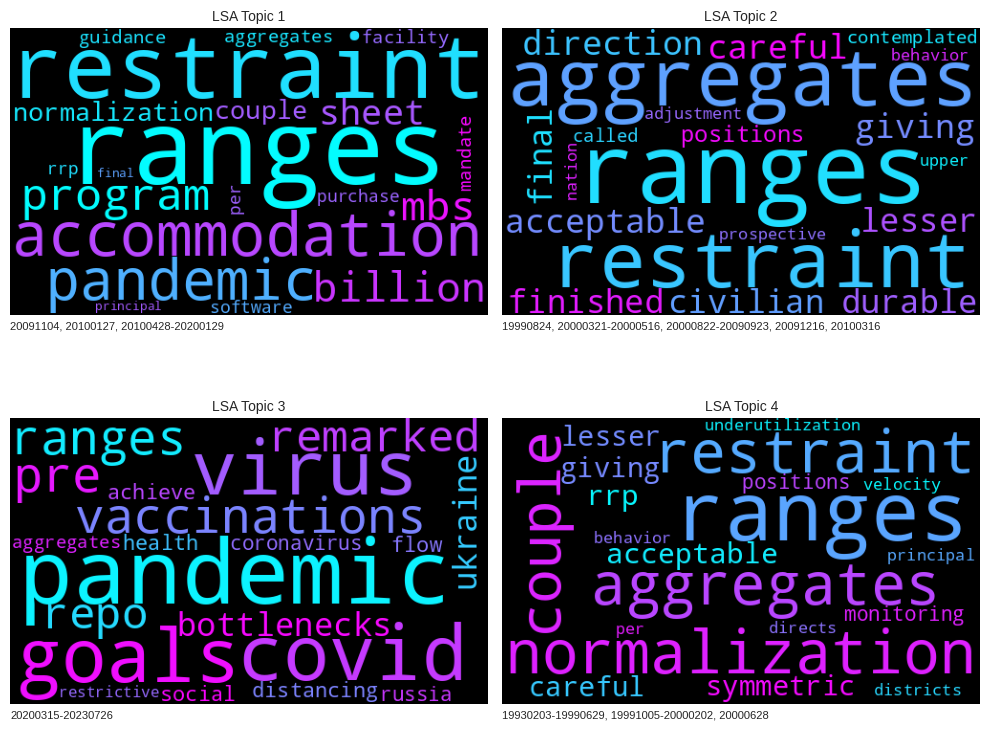

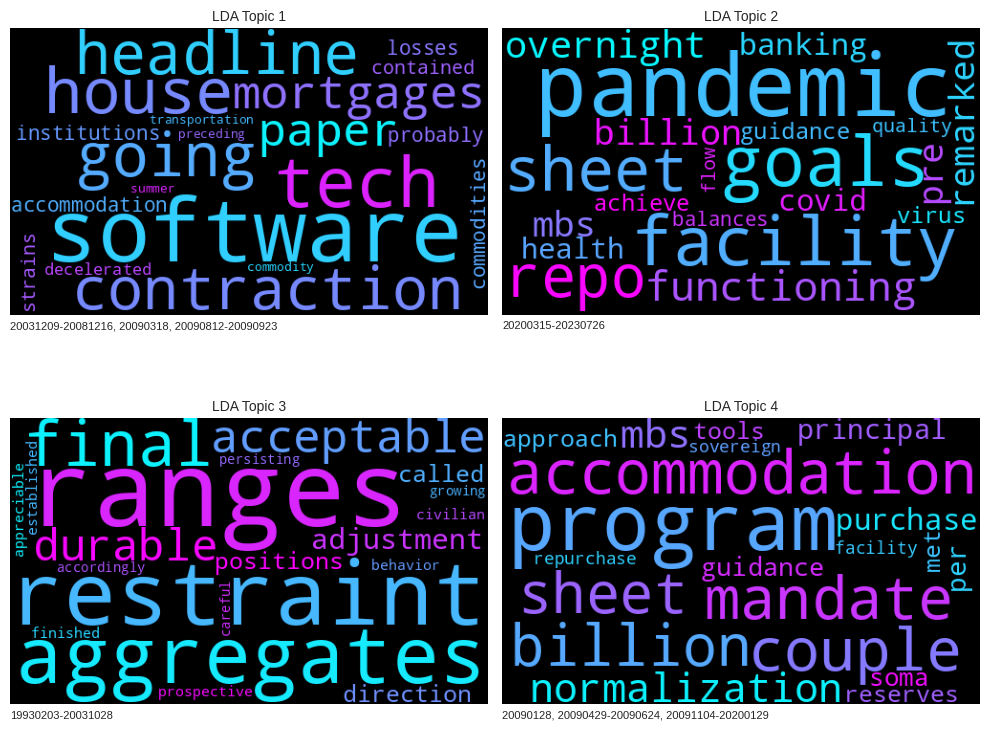

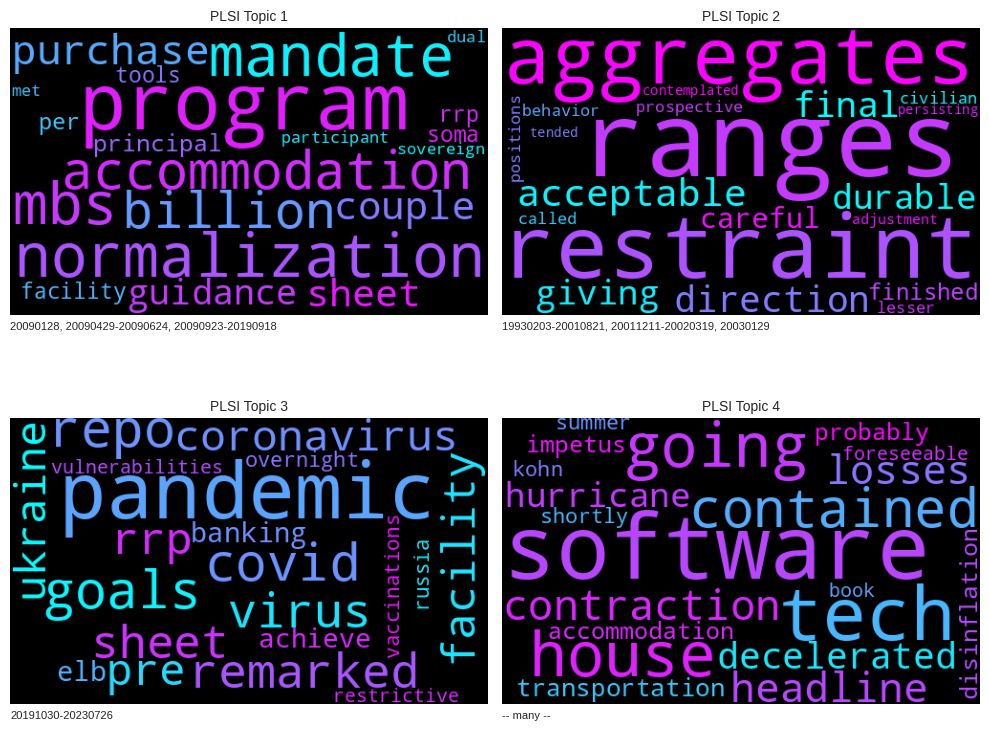

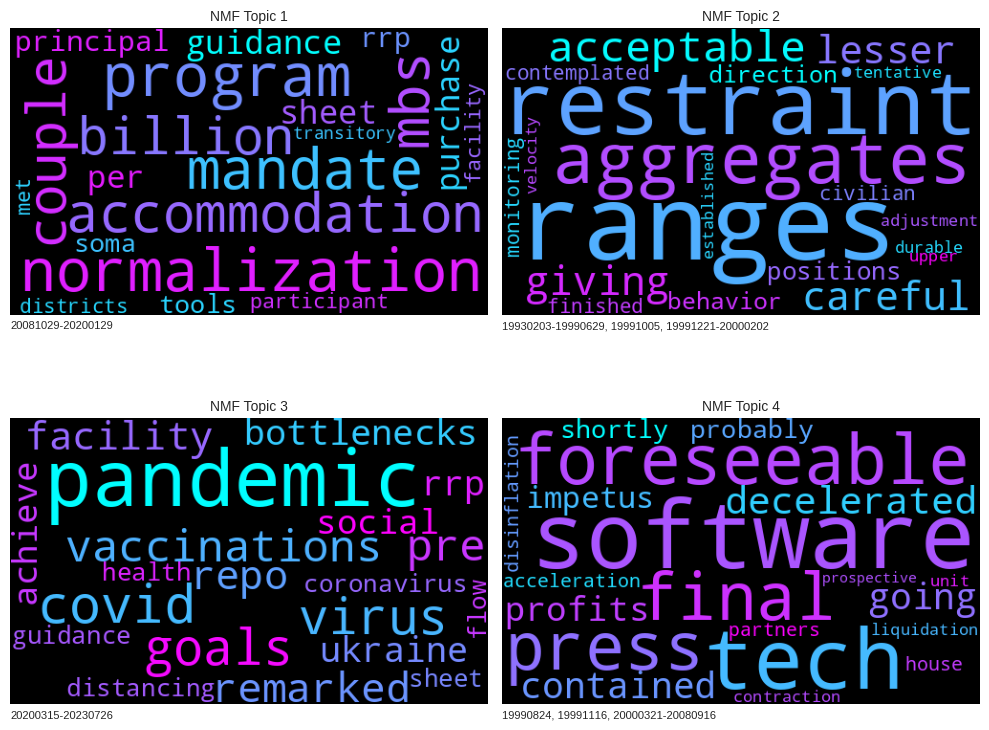

In [12]:
## display top features
figsize = (10, 10) # (5, 5)
for ifig, (name, score) in enumerate(scores.items()):
    wc = WordCloud(height=300, width=500, colormap='cool') 
    top_n = 20
    fig, axes = plt.subplots(2, 2, num=ifig+5, figsize=figsize, clear=True)
    for topic, components in enumerate(score):
        words = {feature_names[i].replace(' ','_') : components[i]
                 for i in components.argsort()[:-top_n - 1:-1]}
        print("Topic", topic+1, dates[name])
        print(list(words.keys()))
        ax = axes[topic//2, topic % 2]
        ax.imshow(wc.generate_from_frequencies(words))
        ax.axes.yaxis.set_visible(False)   # make axes ticks invisible
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.set_title(f"{name} Topic {topic+1}", fontsize=10)
        regime = ", ".join([f"{d[0]}-{d[1]}" if d[0] != d[1] else f"{d[0]}"
                            for d in dates[name][topic]])            
        ax.set_xlabel(regime if len(regime) < 75 else '-- many --',
                      fontsize=8,
                      loc='left')
        plt.tight_layout()
    plt.savefig(imgdir / (name + '_words.jpg'))
plt.show()